## Experiential Task 2
Publicly traded companies announce earnings four times per year. These quarterly announcements convey significant information to the market about the company's performance as well as expectations about performance in the coming period. While Wall Street often focuses on whether earnings-per-share (EPS) "meets or beats" expectations, this metric represents only one data point in the announcement.

Managers supplement announced earnings with a detailed narrative disclosure which provides information helpful for interpreting performance. In this task, we will analyze these narrative disclosures using a few different machine learning approaches. Specifically: 

- We will apply topic modeling to understand the type of language in earnings announcements. 
- We will use Lasso regression to evaluate which topics best predict stock returns.
- We will train a discrete classifier to understand whether earnings announcements can be used to predict large positive returns.

This task will proceed in four general steps:
1. Load the data, pre-process, and extract features needed for our machine learning procedures (20% of grade).
2. Apply LDA to the corpus and inspect the top 5 words associated with each topic (30% of grade).
3. Use Lasso Regression to evaluate which topics most strongly predict stock returns (25% of grade).
4. Use a classifier of your choice to model the extent to which topics or words (your choice) most strongly predict large positive returns (>5% over 3-day period) (25% of grade).

Let's get started!

### Step 1: Prepare the Data
In this step, you should do the following:
1. Load the dataset using pandas. Confirm there are 12,500 rows.
2. Write a function that replaces any financial number with "financial_number. Then the function should filter out "bad" sentences, defined as those with fewer than 5 tokens OR more than 50% financial numbers. 
3. Generate a document term matrix which allows for single words and bigrams. Restrict tokens to only those that are all letters ("alpha") and at least 3 characters, but make sure to allow for "financial_number". Retain the 1,000 most common features, exclude english stop words, and exclude tokens appearing in more than 50% of documents.

#### 1.1 - Load the dataset (ExpTask2Data.csv.gz)
Use pandas to load the dataset, "ExpTask2Data.csv.gz", into a dataframe. Confirm you have 12,500 rows.

In [2]:
# Insert code to load the dataset into a dataframe called "df"

import pandas as pd
df = pd.read_csv('ExpTask2Data.csv.gz')
df

,File_Name,ea_text,datacqtr,announce_date,BHAR0_2
0,714603-0001104659-11-059721.txt,EX-99.1 3 a11-28994_1ex99d1. htm EX-99.1 Exh...,2011Q3,10/28/2011,-4.513975
1,772897-0000950134-06-020331.txt,EX-99.1 2 c09674exv99w1. htm PRESS RELEASE ex...,2006Q3,11/2/2006,-2.001589
2,775158-0001564590-20-048540.txt,EX-99.1 2 osk-ex991_6. htm EX-99.1 osk-ex99...,2020Q3,10/29/2020,-2.112353
3,16040-0001157523-20-000728.txt,EX-99.1 2 a52217903ex99_1. htm EXHIBIT 99.1 ...,2020Q1,5/11/2020,-9.170058
4,29332-0000029332-07-000098.txt,EX-99.1 2 ex991pressrel73107. htm PRESS RELEAS...,2007Q2,7/31/2007,8.671501
...,...,...,...,...,...
12495,883902-0000883902-20-000016.txt,EX-99.1 2 a2019q4exh991. htm EX-99.1 Docum...,2019Q4,3/3/2020,5.110050
12496,917470-0001157523-08-006146.txt,EX-99.1 2 a5744289-ex991. htm EXHIBIT 99.1 ...,2008Q2,7/31/2008,-17.319616
12497,1058090-0001193125-07-166748.txt,EX-99.1 2 dex991. htm PRESS RELEASE Press Rel...,2007Q2,7/31/2007,26.078641
12498,1049502-0001299933-09-002997.txt,EX-99.1 2 exhibit1. htm EX-99.1 EX-99.1 (...,2009Q2,7/22/2009,8.731096


#### 1.2 - Clean out the "bad" sentences
Fill in the following function based on the criteria given above. I recommend taking the following approach (and I have sketched out a function you can update) but you are free to handle this part of the task as you wish:
- Generate a list of sentences with `sent_tokenize`
- Loop over each sentence
- Identify financial numbers with a regular expression, and replace those with "financial_number".
- Tokenize words in the sentence with `word_tokenize`, and filter out non-alpha or non-"financial_number". Retain good tokens in `good_tokens`.
- Evaluate sentence per the parameters above (5 or more tokens, no more than 50% financial numbers)

In [4]:
import re
from nltk.tokenize import sent_tokenize, word_tokenize

def clean_sentences(txt):
    # add regular expression to "..." to clean out financial numbers:
    clean_txt = re.sub(r"\b\d+(?:,\d{3})*(?:\.\d+)?\b"," financial_number ",txt)
    sentences = sent_tokenize(clean_txt)
    good_sents = []
    for sent in sentences:
        words = word_tokenize(sent)
        good_tokens = []
        financial_count = 0
        for word in words:                
            # add code to apply logic above, building list of "good tokens"
            if word.isalpha() or word == 'financial_number':
                good_tokens.append(word)
                if word == 'financial_number':
                    financial_count +=1
                
        # Now add logic to check if there are sufficient tokens to keep the sentence:
        if len(good_tokens) >= 5 and (financial_count / len(good_tokens)) <= 0.5:
            good_sents.append(" ".join(good_tokens))
    
    return " ".join(good_sents)        

Now apply this function to the earnings announcement text ("ea_text"), placing the result in a new dataframe column called "clean_sent" (this will likely take 15-20 minutes, so you may want test your function on a smaller sample before applying to the full dataframe).

In [6]:
df['clean_sent'] = df['ea_text'].apply(clean_sentences)
df

,File_Name,ea_text,datacqtr,announce_date,BHAR0_2,clean_sent
0,714603-0001104659-11-059721.txt,EX-99.1 3 a11-28994_1ex99d1. htm EX-99.1 Exh...,2011Q3,10/28/2011,-4.513975,htm financial_number Exhibit financial_number ...
1,772897-0000950134-06-020331.txt,EX-99.1 2 c09674exv99w1. htm PRESS RELEASE ex...,2006Q3,11/2/2006,-2.001589,htm PRESS RELEASE EXHIBIT financial_number MED...
2,775158-0001564590-20-048540.txt,EX-99.1 2 osk-ex991_6. htm EX-99.1 osk-ex99...,2020Q3,10/29/2020,-2.112353,htm Exhibit financial_number O S H K O S H C O...
3,16040-0001157523-20-000728.txt,EX-99.1 2 a52217903ex99_1. htm EXHIBIT 99.1 ...,2020Q1,5/11/2020,-9.170058,htm EXHIBIT financial_number Exhibit financial...
4,29332-0000029332-07-000098.txt,EX-99.1 2 ex991pressrel73107. htm PRESS RELEAS...,2007Q2,7/31/2007,8.671501,htm PRESS RELEASE THE DIXIE GROUP INC EXHIBIT ...
...,...,...,...,...,...,...
12495,883902-0000883902-20-000016.txt,EX-99.1 2 a2019q4exh991. htm EX-99.1 Docum...,2019Q4,3/3/2020,5.110050,htm financial_number DocumentNEWS RELEASECorne...
12496,917470-0001157523-08-006146.txt,EX-99.1 2 a5744289-ex991. htm EXHIBIT 99.1 ...,2008Q2,7/31/2008,-17.319616,htm EXHIBIT financial_number Exhibit financial...
12497,1058090-0001193125-07-166748.txt,EX-99.1 2 dex991. htm PRESS RELEASE Press Rel...,2007Q2,7/31/2007,26.078641,htm PRESS RELEASE Press Release Exhibit financ...
12498,1049502-0001299933-09-002997.txt,EX-99.1 2 exhibit1. htm EX-99.1 EX-99.1 (...,2009Q2,7/22/2009,8.731096,htm financial_number financial_number MKS LOGO...


Before we generate the document term matrix, I'd recommend saving this dataframe so you don't have to re-run that code when continuing:

In [8]:
# To save:
df.to_csv("./task2_data_clean.csv.gz",index=False)

In [9]:
# To load:
df = pd.read_csv("./task2_data_clean.csv.gz")

In [10]:
df

,File_Name,ea_text,datacqtr,announce_date,BHAR0_2,clean_sent
0,714603-0001104659-11-059721.txt,EX-99.1 3 a11-28994_1ex99d1. htm EX-99.1 Exh...,2011Q3,10/28/2011,-4.513975,htm financial_number Exhibit financial_number ...
1,772897-0000950134-06-020331.txt,EX-99.1 2 c09674exv99w1. htm PRESS RELEASE ex...,2006Q3,11/2/2006,-2.001589,htm PRESS RELEASE EXHIBIT financial_number MED...
2,775158-0001564590-20-048540.txt,EX-99.1 2 osk-ex991_6. htm EX-99.1 osk-ex99...,2020Q3,10/29/2020,-2.112353,htm Exhibit financial_number O S H K O S H C O...
3,16040-0001157523-20-000728.txt,EX-99.1 2 a52217903ex99_1. htm EXHIBIT 99.1 ...,2020Q1,5/11/2020,-9.170058,htm EXHIBIT financial_number Exhibit financial...
4,29332-0000029332-07-000098.txt,EX-99.1 2 ex991pressrel73107. htm PRESS RELEAS...,2007Q2,7/31/2007,8.671501,htm PRESS RELEASE THE DIXIE GROUP INC EXHIBIT ...
...,...,...,...,...,...,...
12495,883902-0000883902-20-000016.txt,EX-99.1 2 a2019q4exh991. htm EX-99.1 Docum...,2019Q4,3/3/2020,5.110050,htm financial_number DocumentNEWS RELEASECorne...
12496,917470-0001157523-08-006146.txt,EX-99.1 2 a5744289-ex991. htm EXHIBIT 99.1 ...,2008Q2,7/31/2008,-17.319616,htm EXHIBIT financial_number Exhibit financial...
12497,1058090-0001193125-07-166748.txt,EX-99.1 2 dex991. htm PRESS RELEASE Press Rel...,2007Q2,7/31/2007,26.078641,htm PRESS RELEASE Press Release Exhibit financ...
12498,1049502-0001299933-09-002997.txt,EX-99.1 2 exhibit1. htm EX-99.1 EX-99.1 (...,2009Q2,7/22/2009,8.731096,htm financial_number financial_number MKS LOGO...


#### Step 1.3
Now we will generate our document term matrix. Note that you need use `CountVectorizer` since we are going to use LDA. I've provided you the token pattern that will allow financial_number as a single token.

In [12]:
#Generate a document term matrix which allows for single words and bigrams. 
#Restrict tokens to only those that are all letters ("alpha") and at least 3 characters, 
#but make sure to allow for "financial_number". Retain the 1,000 most common features, exclude english stop words, 
#and exclude tokens appearing in more than 50% of documents.


from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
stops = set(stopwords.words('english'))

# Update with parameters needed per instructions; I've provided a token_pattern
vec = CountVectorizer(token_pattern = r'\b[a-zA-Z_]{3,}[a-zA-Z]*\b', 
        stop_words = list(stops), 
        ngram_range = (1,2),
        max_features= 1000,
        max_df = 0.5) 
dtm = vec.fit_transform(df['clean_sent'])

In [13]:
dtm

<12500x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 3502566 stored elements in Compressed Sparse Row format>

### Step 2: Fitting the LDA Model
Next, we're going to generate topics from our document term matrix using LDA. We'll do this step in four parts:
1. Fitting LDA model over a range of topics
2. Evaluating diagnostics to select "best" choice
3. Fit a final model and generate topic scores
4. Evaluate top 5 words in each topic

#### 2.1 - Tuning LDA
As in demo 5A, I suggest using `sklearn`'s implementation of LDA, which is the best option for generating topical relevance at the document level. We need to do a little tuning for our model. I recommend doing this on a smaller sample of 5,000 records to save time. You should try between 40 and 150 topics, counting by 10s. You should set `topic_word_prior` equal to 0.15 and `doc_topic_prior` to 25 divided by the number of topics. Finally, we will use the coherence score, `u_mass`, as in demo 5A to evaluate topic quality. 

I've set up a tuning loop for you to use. Fill in the code as needed:

In [15]:
#!pip install tmtoolkit

In [16]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim
import numpy as np

# Select a sample of 5000 for training; use random_state=123
sample = pd.DataFrame(dtm.todense()).sample(5000,random_state=123)

# Set up "vocab", a list of feature names
vocab = np.array(vec.get_feature_names_out())


# Set up empty list to collect diagnostics
records = []
for top in range(40, 151, 10): 
    print(f"Fitting {top} topics")
    record = {'topics':top}
    # Fill in missing parameters
    lda = LDA(n_components = top,
              doc_topic_prior = 25/top,
              topic_word_prior = 0.15,
              n_jobs = -1,
              random_state=123)

    doc_topics = lda.fit_transform(dtm) # Add code to fit the the model
    
    ## Add code to compute umass, add mean umass to "record", and collect record in list
    top_word = lda.components_
    umass = metric_coherence_gensim(measure= 'u_mass',
                                      topic_word_distrib = top_word,
                                      dtm = sample.values,
                                      vocab=np.array(vocab),
                                      top_n=10,
                                      texts= None)
    record['mean_umass'] = np.mean(umass)
    records.append(record)

Fitting 40 topics
Fitting 50 topics
Fitting 60 topics
Fitting 70 topics
Fitting 80 topics
Fitting 90 topics
Fitting 100 topics
Fitting 110 topics
Fitting 120 topics
Fitting 130 topics
Fitting 140 topics
Fitting 150 topics


#### 2.2 - Evaluating `umass` and selecting number of topics for final model
In this step, you should plot `umass` over the range of topics ran in the previous step. Show your plot and then choose the optimum number of topics based on your plot. You are free to use whatever plotting approach you wish. 

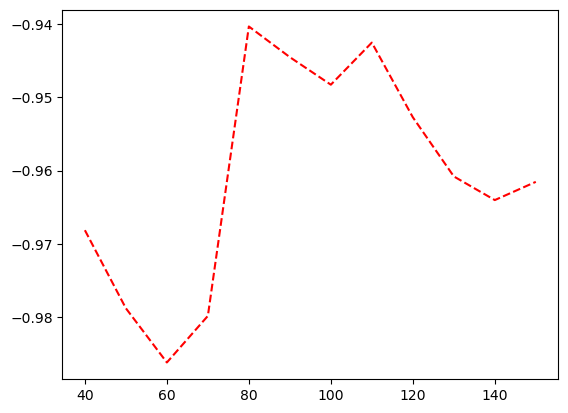

In [18]:
import matplotlib.pyplot as plt

diagnostics = pd.DataFrame(records)
diagnostics

fig,ax= plt.subplots()
ax.plot(diagnostics['topics'], diagnostics['mean_umass'], color='red', linestyle='--')

**Interpret your plot and comment on the number of topics you plan to use:**

*My answer:* As you can observe in the plot, the chart goes up and peaks at around 80 topics with a mean_umass value of -0.94. Therefore, I will try to cap it at 90 topics. For umass, higher is better so I can do a range of 60-80 topics.

#### Step 2.3
Now, fit a final LDA model using the number of topics chosen in the prior step and use it to transform the data.

In [21]:
# Set up final lda model:

records = []
for top in range(60, 80, 10): 
    print(f"Fitting {top} topics")
    record = {'topics':top}
    # Fill in missing parameters
    final_lda = LDA(n_components = 10,
              doc_topic_prior = 25/top,
              topic_word_prior = 0.15,
              n_jobs = -1,
              random_state=123)

# Fit final model and transform the DTM
topics = final_lda.fit_transform(dtm)

Fitting 60 topics
Fitting 70 topics


In [22]:
topics # view topics matrix


array([[2.13485613e-04, 4.55407419e-01, 2.31691856e-04, ...,
        9.72086055e-02, 2.16387674e-02, 2.39112393e-04],
       [4.46972501e-01, 5.64689523e-02, 7.14239363e-04, ...,
        5.43556681e-03, 6.71249740e-04, 4.34491251e-02],
       [4.42367576e-01, 1.31774227e-01, 6.60648767e-03, ...,
        3.45300767e-04, 2.31904005e-03, 4.13955959e-04],
       ...,
       [9.34602682e-04, 8.90082491e-04, 8.74983683e-04, ...,
        3.13620956e-01, 9.23738330e-04, 9.04597809e-04],
       [8.09143994e-04, 8.81390667e-04, 1.71016283e-02, ...,
        2.36901887e-01, 8.60826047e-04, 1.35203330e-02],
       [4.48449096e-03, 3.54973646e-01, 1.52135290e-02, ...,
        6.40519775e-04, 7.14306058e-04, 6.71136920e-04]])

#### 2.4 - Evaluate topic words
The final step in this part of the task is to evaluate the words in your topics. Word intrusion tasks are a good way to validate topics in an objective manner. We will not follow through on a full word intrusion task, but I would like you to display the top 5 words in each topic and a randomly chosen word from the vocabulary, separately identified as an intruder.

Fill in this code to generate the top 5 words in each topic plus an intruder:

In [41]:
import random
topn = 5
topics= top_word.shape[0]
# You need these two objects:
vocab = np.array(vec.get_feature_names_out())
top_word = final_lda.components_

def get_topic_words(topic, top_word, vocab, topn=5):
    top_words = top_word[topic,:].argsort()[-topn:][::-1].tolist()
    return vocab[top_words]

# Insert code to perform the intrusion task
for top in range(topics):
    words = get_topic_words(top, top_word, vocab, topn=5)
    random_word = random.sample(list([w for w in vocab if w not in words]),1)[0] 
    print(f"Topic {top}: {'|'.join(words)}\t\tIntruder:{random_word}")

Topic 0: fiscal|fiscal financial_number|quarter fiscal|fiscal year|financial_number fiscal		Intruder:stated
Topic 1: third quarter|september|september financial_number|ended september|nine		Intruder:make
Topic 2: continuing|continuing operations|discontinued|discontinued operations|income continuing		Intruder:gains losses
Topic 3: net loss|intangible assets|income loss|operating expenses|compensation expense		Intruder:new products
Topic 4: percent|financial_number percent|billion|financial_number billion|percent financial_number		Intruder:call available
Topic 5: ended december|attributable|ebitda|adjusted ebitda|year ended		Intruder:twelve months
Topic 6: net sales|currency|foreign|retail|gross profit		Intruder:ended financial_number
Topic 7: june|june financial_number|ended june|six|six months		Intruder:special items
Topic 8: ebitda|adjusted ebitda|financial_number adjusted|adjusted net|ebitda financial_number		Intruder:website www
Topic 9: production|oil|gas|natural|natural gas		Intr

In [43]:
df

,File_Name,ea_text,datacqtr,announce_date,BHAR0_2,clean_sent
0,714603-0001104659-11-059721.txt,EX-99.1 3 a11-28994_1ex99d1. htm EX-99.1 Exh...,2011Q3,10/28/2011,-4.513975,htm financial_number Exhibit financial_number ...
1,772897-0000950134-06-020331.txt,EX-99.1 2 c09674exv99w1. htm PRESS RELEASE ex...,2006Q3,11/2/2006,-2.001589,htm PRESS RELEASE EXHIBIT financial_number MED...
2,775158-0001564590-20-048540.txt,EX-99.1 2 osk-ex991_6. htm EX-99.1 osk-ex99...,2020Q3,10/29/2020,-2.112353,htm Exhibit financial_number O S H K O S H C O...
3,16040-0001157523-20-000728.txt,EX-99.1 2 a52217903ex99_1. htm EXHIBIT 99.1 ...,2020Q1,5/11/2020,-9.170058,htm EXHIBIT financial_number Exhibit financial...
4,29332-0000029332-07-000098.txt,EX-99.1 2 ex991pressrel73107. htm PRESS RELEAS...,2007Q2,7/31/2007,8.671501,htm PRESS RELEASE THE DIXIE GROUP INC EXHIBIT ...
...,...,...,...,...,...,...
12495,883902-0000883902-20-000016.txt,EX-99.1 2 a2019q4exh991. htm EX-99.1 Docum...,2019Q4,3/3/2020,5.110050,htm financial_number DocumentNEWS RELEASECorne...
12496,917470-0001157523-08-006146.txt,EX-99.1 2 a5744289-ex991. htm EXHIBIT 99.1 ...,2008Q2,7/31/2008,-17.319616,htm EXHIBIT financial_number Exhibit financial...
12497,1058090-0001193125-07-166748.txt,EX-99.1 2 dex991. htm PRESS RELEASE Press Rel...,2007Q2,7/31/2007,26.078641,htm PRESS RELEASE Press Release Exhibit financ...
12498,1049502-0001299933-09-002997.txt,EX-99.1 2 exhibit1. htm EX-99.1 EX-99.1 (...,2009Q2,7/22/2009,8.731096,htm financial_number financial_number MKS LOGO...


### Step 3: Using Lasso to evaluate topic informativeness
In this portion of the task, you'll use Lasso regression to evaluate which topics exhibit the strongest associations with stock returns, which is labeled as "BHAR0_2" (or buy-and-hold abnormal returns from days 0 to 2). Note that this column is in percentage points (i.e., -4.5 indicates a return of -4.5%).

You should proceed as follows:
1. Identify the optimum out-of-sample value for `alpha` (the primary regularization parameter) using `RandomizedSearchCV`. You should try 100 random values in the range between 0.00001 and 0.02.
2. Analyze results of the best fit models. How many topics exhibit non-zero associations with returns? Which topic exhibits the strongest negative and positive associations (two total)?

#### 3.1 - Tuning the Lasso model
To tune the model, you first need do split your data into a training and testing sample. I've set most of this up for you; Replace `X` and `Y` with the datasets needed to conduct this test and update the function have a training sample of 80% and validation sample of 20%:

In [46]:
from sklearn.model_selection import train_test_split

Xtopic_train, Xtopic_test, Ytopic_train, Ytopic_test = train_test_split(dtm,df['BHAR0_2'],test_size=0.20,random_state=123)

Next, you should set up your lasso model, parameter grid, and randomized searcher. Use these parameters for the search:
- You parameter grid should include 100 random values for `alpha` between 0.00001 and 0.02. 
- Your randomized search should run 50 times and use 5-fold cross-validation. 
- You should use `neg_root_mean_squared_error` for scoring.
- You should use `random_state=123` wherever possible.

Fill in the code below to set this up:

In [49]:
Xtopic_train

<10000x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 2799289 stored elements in Compressed Sparse Row format>

In [51]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Lasso

np.random.seed(123)

alphas = [i/100 for i in range(1,101)]
params = {'alpha':alphas,'random_state':[123]}


lasso = Lasso(max_iter= 1000)
lasso.fit(Xtopic_train, Ytopic_train)

rus = RandomizedSearchCV(lasso,params,
                        # Update with rest of parameters
                        n_iter = 50,
                        scoring= 'neg_root_mean_squared_error',
                        random_state = 123,
                        cv= 5,
                        n_jobs = -1 # Optional
)
rus.fit(Xtopic_train, Ytopic_train)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9310.310579347191, tolerance: 68.75823695635627
  model = cd_fast.sparse_enet_coordinate_descent(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4464.107547527179, tolerance: 69.09814572686872
  model = cd_fast.sparse_enet_coordinate_descent(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 473.3288310612552, tolerance: 68.75317585543273
  model = cd_fast.sparse_enet_coordinate_descent(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.

RandomizedSearchCV(cv=5, estimator=Lasso(), n_iter=50, n_jobs=-1,
                   param_distributions={'alpha': [0.01, 0.02, 0.03, 0.04, 0.05,
                                                  0.06, 0.07, 0.08, 0.09, 0.1,
                                                  0.11, 0.12, 0.13, 0.14, 0.15,
                                                  0.16, 0.17, 0.18, 0.19, 0.2,
                                                  0.21, 0.22, 0.23, 0.24, 0.25,
                                                  0.26, 0.27, 0.28, 0.29, 0.3, ...],
                                        'random_state': [123]},
                   random_state=123, scoring='neg_root_mean_squared_error')

To evaluate performance by `alpha`, prepare a scatter plot that shows the validation `neg_root_mean_squared_error` vs. `alpha` (**HINT**: results from the randomized search are in `rus.cv_results_`, which is a dictionary).

In [54]:
rus.cv_results_.keys()


dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_random_state', 'param_alpha', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

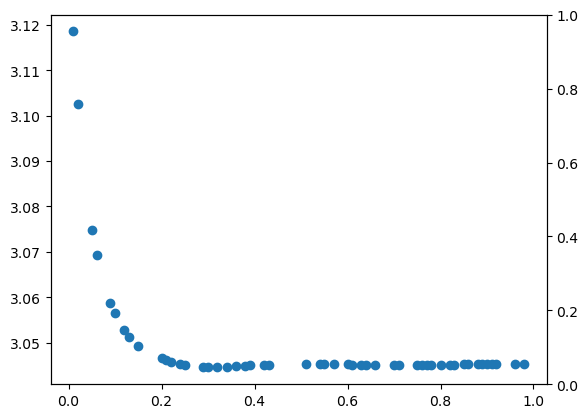

In [56]:
import matplotlib.pyplot as plt

neg_mse_scores = rus.cv_results_['mean_test_score']
rmse_scores = np.sqrt(-neg_mse_scores)
           
fig,ax = plt.subplots()
ax2 = ax.twinx()
ax.scatter(rus.cv_results_['param_alpha'].data,rmse_scores)
#ax2.plot(gs.cv_results_['param_alpha'],gs.cv_results_['mean_test_r2'],color='red')

Now print the optimum value for `alpha`:

In [59]:
print(rus.cv_results_['param_alpha'])

[0.09 0.71 0.83 0.29 0.64 0.01 0.06 0.51 0.82 0.05 0.24 0.66 0.77 0.61
 0.25 0.43 0.78 0.39 0.57 0.76 0.36 0.89 0.2 0.3 0.32 0.92 0.86 0.1 0.54
 0.42 0.22 0.91 0.34 0.7 0.85 0.88 0.96 0.98 0.63 0.13 0.21 0.9 0.38 0.6
 0.02 0.75 0.12 0.8 0.15 0.55]


#### 3.2 Interpreting Lasso results
To finish up this step, I'd like you to identify:

1. How many coefficients (each of which corresponds to a topic) are non-zero
2. Which topic has the most negative coefficient?
3. Which topic has the most positive coefficient?

Let's start with non-zero coefficients. Fill in the cell below to print out the number of coefficients not equal to zero:

In [62]:
non_zero_coefficients = np.sum(lasso.coef_ != 0)
print(f"Number of non-zero coefficients (topics): {non_zero_coefficients}")

Number of non-zero coefficients (topics): 4


Now identify the most positive and most negative topics and print associated words (**HINT**: `argmax()` and `argmin()` make this very straightforward). 

Print out both the values of these coefficients and their indices:

In [65]:
most_pos = np.argmin(lasso.coef_)
most_neg = np.argmax(lasso.coef_)

print(f"The most positive coefficient corresponds to topic {most_pos} and has a value {lasso.coef_[most_pos]}.")
print(f"The most negative coefficient corresponds to topic {most_neg} and has a value {lasso.coef_[most_neg]}.")

The most positive coefficient corresponds to topic 612 and has a value -0.08829073063715437.
The most negative coefficient corresponds to topic 812 and has a value 0.025796798431874154.


In [67]:
top_word[:-6:-1]

array([[ 474.0713571 ,  337.54028436,  579.3316811 , ...,  101.69979534,
          65.01213493,  837.84737312],
       [1730.95984776, 1254.36043657, 1512.82516067, ...,  598.30214119,
         913.71599367, 1465.27975695],
       [ 488.27813319,  345.58823328,  489.37496222, ...,  366.47631148,
          62.82979088,  153.15582037],
       [ 731.49879828,  454.58858594, 1326.57708219, ..., 2162.9350528 ,
         723.0681515 , 1833.46027785],
       [1082.68909528,  706.88767803, 1004.92252137, ..., 1084.32644753,
         427.90704382, 1598.88980429]])

In [69]:
top_words_pos = top_word[5,:].argsort()[:5].tolist()
top_words_neg = top_word[5, :].argsort()[:-6:-1].tolist()

# Retrieve the actual words from the vocabulary
words_pos = vocab[top_words_pos]
words_pos
words_neg = vocab[top_words_neg]
words_neg

array(['ended december', 'attributable', 'ebitda', 'adjusted ebitda',
       'year ended'], dtype=object)

Now, print the top 5 words corresponding to each of these two topics:

In [72]:
# Positive words:
words_pos = vocab[top_words_pos] # format as list
print(f"Topic {most_pos} words: {'|'.join(words_pos)}")

# Negative words:
words_neg = vocab[top_words_neg] # format as list
print(f"Topic {most_neg} words: {'|'.join(words_neg)}")

Topic 612 words: natural gas|crude|drilling|exploration|gas
Topic 812 words: ended december|attributable|ebitda|adjusted ebitda|year ended


**QUESTION**: Do you find this answer intuitive? Why or why not?

*INSERT ANSWER HERE*: It is interesting to see the most positive and negative words. Positive words are all about extraction and energy so that makes sense whreas the negative words are about financial performance metrics and year end.

### Step 4: Use a classifier to predict large positive returns
The final part of this task is to use a classifier of your choice to predict large positive returns. You can use the document-term matrix or topic-matrix. You're also free to tune the model as you wish. Training classifiers can be time consuming, so I'm going to use an approach to this section called *specification grading*, meaning you can choose to omit parts of the process for a reduced grade.

Grading for this part will be done as follows:

1. Set up, train, and evaluate at least one classifier: If this portion is done perfectly and nothing else is done, you'll receive 50% credit for this part.
2. Apply robust tuning procedures to one or more models: If you tune multiple hyperparameters for the one model you fit in step 1, you'll receive an additional 10-20% (max grade 70%) credit, depending on extent of tuning. If you tune two or more models properly, this scale increases to 20-40% (max grade 90%).
3. Finally, the last 10% will be based on your best fit model. Specifically, using the validation data set up below, you should print your classification report. The best macro-F1 score in the class will receive 10% (100% cumulative) second best 9.5%, and so forth.

#### 4.1 - Data set-up an single model training
I'll help you set up the data so we all start from the same place. Note that I'm going to set up two sets of "X" data, one based on the DTM and the other on the topic matrix. You can use either (or both if you consider multiple models):

In [78]:
YLR = (df['BHAR0_2']>5).astype(int)
topics = lda.transform(dtm)
train_Xdtm, test_Xdtm, train_Xtopic, test_Xtopic, train_YLR, test_YLR = train_test_split(np.asarray(dtm.todense()),topics,YLR,train_size=0.80,random_state=123)

Next, you should fill in the cell below with code to train at least one model:

In [81]:
# Train and evaluate at least one model
# model 1 = lightgbm
from lightgbm import LGBMClassifier as LGBM

lgbm = LGBM(reg_alpha=0.01, random_state=123, n_jobs=-1)
lgbm.fit(train_Xdtm,train_YLR)

# from sklearn.svm import SVR # actually dont use SVR and something else!
# svr = SVR()
# svr.fit(trainXdtm, train_YLR)

[LightGBM] [Info] Number of positive: 2416, number of negative: 7584
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19561
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 1000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.241600 -> initscore=-1.143927
[LightGBM] [Info] Start training from score -1.143927


LGBMClassifier(n_jobs=-1, random_state=123, reg_alpha=0.01)

In [83]:
#model 2
from sklearn.naive_bayes import GaussianNB as NBC

nbc=NBC()
nbc.fit(train_Xdtm,train_YLR)

GaussianNB()

In [85]:
#model 3
from sklearn.tree import DecisionTreeClassifier as DTC

tree= DTC(max_depth =200, max_features = 'sqrt', random_state= 123)
tree.fit(train_Xdtm, train_YLR)



DecisionTreeClassifier(max_depth=200, max_features='sqrt', random_state=123)

In [106]:
from sklearn.tree import DecisionTreeClassifier as DTC

#model 3.1
tree= DTC(max_depth =200, max_features = 'sqrt', random_state= 123)
tree.fit(train_Xdtm, train_YLR)


DecisionTreeClassifier(max_depth=200, max_features='sqrt', random_state=123)

In [108]:
#model 4: random forest
from sklearn.ensemble import RandomForestClassifier as RFC

rf = RFC(n_jobs= -1, random_state=123, class_weight='balanced')
rf.fit(train_Xdtm, train_YLR)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=123)

#### 4.2 - Model Tuning
Here, you should insert code you use to tune your classifier. You can insert additional cells if needed, or skip this step and accept a lower grade if desired.

In [111]:
nbc2= NBC(var_smoothing=1)
nbc2.fit(train_Xdtm,train_YLR)

GaussianNB(var_smoothing=1)

In [113]:
YLR.value_counts()


BHAR0_2
0    9488
1    3012
Name: count, dtype: int64

In [140]:
#model tree2, decision tree 2
cws= {0:1,1:3}
tree2= DTC(max_depth =200, max_features = 'sqrt', random_state= 123, class_weight=cws)
tree2.fit(train_Xdtm, train_YLR)


DecisionTreeClassifier(class_weight={0: 1, 1: 3}, max_depth=200,
                       max_features='sqrt', random_state=123)

In [154]:
#model rf2, random forest 2
rf2 = RFC(n_estimators = 50, max_depth= 10, n_jobs= -1, random_state=123, class_weight='balanced')
rf2.fit(train_Xdtm, train_YLR)

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=50,
                       n_jobs=-1, random_state=123)

In [117]:
# Update with tuning code if desired
from scipy.stats import uniform
uni = uniform(0.0005, 0.10)
uni.rvs()

gamma_dist = uniform(0.0005, 0.10)
C_dist = uniform(0.1,1.25)

params = {'kernel':['poly','rbf','sigmoid'],'degree':[2,3,4,5],'gamma': gamma_dist,'C': C_dist}

#### 4.3 - Report final classification report
Here, you should report your final classification report:

In [160]:
from sklearn.metrics import classification_report
# Update "mod" to be your final model and "test_Xdtm" to be whatever X you used)

#RANDOM FOREST , this ** MODEL HAD BEST RESULTS **
print(classification_report(test_YLR,rf.predict(test_Xdtm)))


              precision    recall  f1-score   support

           0       0.76      0.98      0.86      1904
           1       0.39      0.03      0.06       596

    accuracy                           0.76      2500
   macro avg       0.58      0.51      0.46      2500
weighted avg       0.67      0.76      0.67      2500



Other Models tested

In [162]:
#LightGBM
print(classification_report(test_YLR,lgbm.predict(test_Xdtm)))


              precision    recall  f1-score   support

           0       0.76      0.98      0.86      1904
           1       0.35      0.04      0.07       596

    accuracy                           0.75      2500
   macro avg       0.56      0.51      0.46      2500
weighted avg       0.67      0.75      0.67      2500



In [122]:
#Decision Tree
print(classification_report(test_YLR,tree.predict(test_Xdtm)))



              precision    recall  f1-score   support

           0       0.77      0.72      0.75      1904
           1       0.26      0.31      0.28       596

    accuracy                           0.62      2500
   macro avg       0.51      0.52      0.51      2500
weighted avg       0.65      0.62      0.64      2500



In [124]:
#NAIVE BAYES

print(classification_report(test_YLR,nbc.predict(test_Xdtm)))


              precision    recall  f1-score   support

           0       0.77      0.32      0.46      1904
           1       0.24      0.69      0.36       596

    accuracy                           0.41      2500
   macro avg       0.51      0.51      0.41      2500
weighted avg       0.64      0.41      0.43      2500



              precision    recall  f1-score   support

           0       0.76      0.98      0.86      1904
           1       0.39      0.03      0.06       596

    accuracy                           0.76      2500
   macro avg       0.58      0.51      0.46      2500
weighted avg       0.67      0.76      0.67      2500



In [128]:
#TREE 2,
print(classification_report(test_YLR,tree2.predict(test_Xdtm)))


              precision    recall  f1-score   support

           0       0.76      0.75      0.76      1904
           1       0.25      0.27      0.26       596

    accuracy                           0.63      2500
   macro avg       0.51      0.51      0.51      2500
weighted avg       0.64      0.63      0.64      2500



In [156]:
#RF 2,
print(classification_report(test_YLR,rf2.predict(test_Xdtm)))


              precision    recall  f1-score   support

           0       0.78      0.77      0.78      1904
           1       0.30      0.32      0.31       596

    accuracy                           0.66      2500
   macro avg       0.54      0.54      0.54      2500
weighted avg       0.67      0.66      0.66      2500



In [130]:
#NB 2
print(classification_report(test_YLR,nbc2.predict(test_Xdtm)))

              precision    recall  f1-score   support

           0       0.77      0.88      0.82      1904
           1       0.29      0.16      0.21       596

    accuracy                           0.71      2500
   macro avg       0.53      0.52      0.51      2500
weighted avg       0.65      0.71      0.67      2500

